In [1]:
%matplotlib inline
import calendar
from sklearn.preprocessing import Normalizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import math

# Jupyter notebook settings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [24, 8]

# Dataset feature constants
TARGET_CLASS = ["DEP_DEL15"]
CATEGORICAL = ["CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "DEP_TIME_BLK"]
CONTINUOUS = ["FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS", "LATITUDE", "LONGITUDE",
              "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]
DISCRETE = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER",
            "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH",
            "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT", "AVG_MONTHLY_PASS_AIRLINE", "PLANE_AGE"]

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

# Semester Project - Part 1
*CSPB 3022 Data Science Algorithms - Spring 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB-3022-Data-Science-Project

## Project Topic

**Project goal:**

The goal of this project is to create a binary classifier that predicts whether a domestic flight will be delayed or not. 

**Type of problem:**

This is a binary classification problem. The target class `DEP_DEL15` labels flights as on-time `0` or delayed `1` if the departure time exceeds 15 minutes.

**Project motivation:**

The motivation for this project is to identify when flight delays might not occur given a set of weather and transportation conditions. If we anticipate a delay, perhaps we could plan around it ahead of time. Or, at the very least, we could mentally prepare ourselves and hope we get an aisle seat.


## Dataset

**Dataset Source:**

The dataset used in this project is from kaggle ([source](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations)) and is located in file: `dataset/full_data_flightdelay.csv`

Each row of the dataset corresponds to a domestic airline departure flight and its associated weather for the year of 2019. This dataset has been wrangled and merged by the kaggle source from the following primary sources:

1. Bureau of Transportation statistics: [Link](https://www.transtats.bts.gov/databases.asp?Z1qr_VQ=E&Z1qr_Qr5p=N8vn6v10&f7owrp6_VQF=D)
2. National Centers for Environmental Information (NOAA): [Link](https://www.ncdc.noaa.gov/cdo-web/datasets)

The departure data from the Bureau of Transportation statistics consists of monthly performance reports that contain a plethora of features for domestic departure flights. This is merged with the NOAA data which adds some interesting features that may contribute to flight delays, such as departure wind, snowfall, and precipitation.

**Dataset size and features:**

The dataset is quite large. Each row corresponds to a single domestic departure and the dataset contains over 6 million domestic departures. Here is a summary of the dataset's contents:

* 1.27 GB size
* 6,489,062 rows 
* 26 features 

There are 5 categorical and 21 numeric features. A description of each feature can be found in the file `dataset/documentation.md`.

In [2]:
# Load the dataset
df = pd.read_csv('../dataset/full_data_flightdelay.csv', dtype='unicode')

# A brief look at a random sample of departure flights and some of their features
display(df[['MONTH', 'DEP_DEL15', 'CARRIER_NAME', 'NUMBER_OF_SEATS', 
            'DEPARTING_AIRPORT', 'PLANE_AGE', 'FLT_ATTENDANTS_PER_PASS', 'PRCP', 'SNOW']].sample(n=8, replace=False))

,MONTH,DEP_DEL15,CARRIER_NAME,NUMBER_OF_SEATS,DEPARTING_AIRPORT,PLANE_AGE,FLT_ATTENDANTS_PER_PASS,PRCP,SNOW
3111605,6,0,Mesa Airlines Inc.,76,Norfolk International,5,0.0,0.0,0.0
3658787,7,1,Endeavor Air Inc.,76,John F. Kennedy International,6,0.0,0.0,0.0
6143797,12,0,SkyWest Airlines Inc.,66,General Mitchell Field,14,3.419267401443636e-05,0.0,0.0
1572326,4,0,Southwest Airlines Co.,143,Austin - Bergstrom International,8,6.178236301460919e-05,0.0,0.0
1860569,4,0,Frontier Airlines Inc.,180,Stapleton International,8,0.00011572564827677376,0.0,0.0
1525081,4,1,United Air Lines Inc.,120,Chicago O'Hare International,18,0.00025380424062159367,1.3,0.0
3032008,6,0,Comair Inc.,70,Ronald Reagan Washington National,17,0.0,0.74,0.0
5248182,10,0,American Airlines Inc.,128,Douglas Municipal,19,9.82082928995461e-05,0.19,0.0


## Data cleaning:

**Setting data types**

The data types for each feature are listed as `object` which means they are encoded as a string of varying length. The first cleaning step will be to cast each feature to an appropriate type that we can work with. 

In [3]:
# Cast groups of features from strings to an appropriate data type
df[TARGET_CLASS] = df[TARGET_CLASS].astype(int)
df[CATEGORICAL] = df[CATEGORICAL].astype(str)
df[CONTINUOUS] = df[CONTINUOUS].astype(float)
df[DISCRETE] = df[DISCRETE].astype(int)

# List the features of the first 8 columns and their datatypes
display(df.iloc[:, 0:7].dtypes)

MONTH                  int32
DAY_OF_WEEK            int32
DEP_DEL15              int32
DEP_TIME_BLK          object
DISTANCE_GROUP         int32
SEGMENT_NUMBER         int32
CONCURRENT_FLIGHTS     int32
dtype: object

**Checking for missing values**

Next I will look for any missing values by looking for features with `np.nan` values:


In [4]:
# Sum NaN values in all columns
missing_vals = df.isnull().sum()
print(f"Total missing values in dataset: {missing_vals.sum()}")

Total missing values in dataset: 0


There don't appear to be any missing values in the form of `np.nan`, however there are some empty categorical features listed with `NONE`:

In [5]:
# Search the dataframe for "NONE" string values
none_vals = df[df.eq("NONE").any('columns')]

# Print the name of columns with NONE value and the percentage of the dataset with NONE values
print(f"Columns with NONE values: {df.columns[df.eq('NONE').any('rows')]}")
print(f"Percent of dataset with NONE values: {(len(none_vals) / len(df) * 100):.2f}%")

Columns with NONE values: Index(['PREVIOUS_AIRPORT'], dtype='object')
Percent of dataset with NONE values: 22.33%


22.3% of the dataset has rows with `NONE` values, so it would be costly to drop all rows with this missing value. However, this affects only one feature: `PREVIOUS_AIRPORT`. Given these circumstances, I will keep these rows and note that the feature `PREVIOUS_AIRPORT` is imbalanced.

## Exploratory Data Analysis (EDA):

**Overview: Why EDA?**

Exploratory data analysis is a collection of methods that investigate characteristics and patterns in the dataset which can improve our understanding of the features and their relationships.


**How EDA will be performed:**

I will be using EDA to visualize a variety of relationships between features and the target class `DEP_DEL15`, such as:

1. What numeric features are highly correlated? Are any redundant?
2. How does the frequency of flight delays vary by month or day of the week?
3. Are there certain airlines that experience more frequent delays?

I will begin by looking at the distribution of the target class `DEP_DEL15`.

**Target class distribution**

The distribution of the target class is important because it can affect model selection. If the target class is imbalanced, then the predictive model could be more sensitive to biases and errors.

On-time flights in the dataset: 81.09%
Delayed flights in the dataset: 18.91%


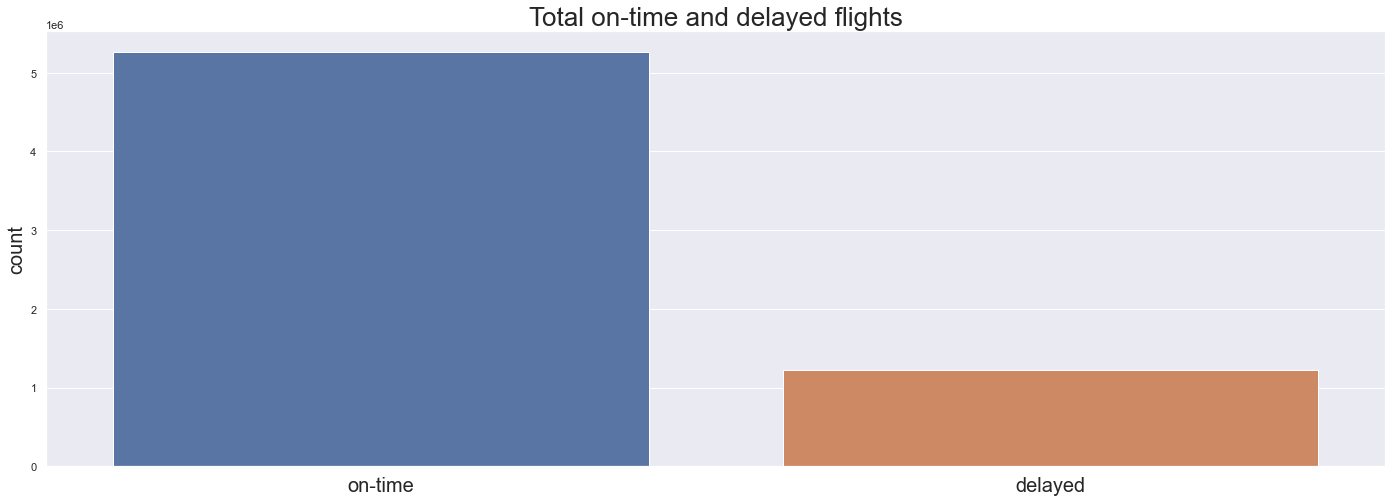

In [6]:
# Create a countplot of our target class
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="DEP_DEL15", data=df)
ax.set_xticks([0, 1], ["on-time", "delayed"], size=20)
ax.set_ylabel("count", fontsize = 20)
ax.set_title("Total on-time and delayed flights", fontdict={'fontsize':26})
ax.set_xlabel(None)

# Print the proportion of each target 
class_targets = df.groupby(['DEP_DEL15']).size()
print(f"On-time flights in the dataset: {class_targets[0]/len(df)*100:.2f}%")
print(f"Delayed flights in the dataset: {class_targets[1]/len(df)*100:.2f}%")

There is a clear bias towards on-time flights, whose proportion is more than 4-times the proportion of delayed flights. This imbalance will need to be considered when we select our model.

**Mean and standard deviation of numeric features**

Next I will have a quick look at some descriptive statistics for numeric features to get a handle on where the averages are. It is also interesting to see where some differences might exist for flights that are delayed, however we cannot say whether any differences are statistically significant without further analysis. First I will compute the mean and standard deviation for delayed flights:

In [7]:
# Select numeric features, exluding month and day of week
numeric = df[TARGET_CLASS + CONTINUOUS + DISCRETE]
numeric = numeric.loc[:, ~numeric.columns.isin(['MONTH', 'DAY_OF_WEEK'])]

# Select delayed flights only
delayed_numeric = numeric[numeric['DEP_DEL15'] == 1]

# Compute the mean and standard deviation for numeric features of delayed flights
print("DELAYED FLIGHTS:")
display(delayed_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

DELAYED FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,1.00,0.00,0.00,36.71,-93.25,0.16,0.06,0.13,71.13,8.72,3.90,3.47,28.24,134.88,13174.01,63211.75,3579.94,1645375.69,7828102.68,11.62
std,0.00,0.00,0.00,5.25,16.81,0.43,0.49,0.86,19.24,3.78,2.38,1.77,21.30,46.48,8731.56,35100.32,4094.56,1095573.89,5043404.98,6.77


Next, I will compute the same for on-time flights:

In [8]:
# Select on-time flights only
ontime_numeric = numeric[numeric['DEP_DEL15'] == 0]

# Compute the mean and standard deviation for numeric features of on-time flights
print("ON-TIME FLIGHTS:")
display(ontime_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

ON-TIME FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,0.00,0.00,0.00,36.70,-94.49,0.09,0.02,0.08,71.55,8.25,3.80,2.95,27.74,133.47,12570.41,62901.99,3431.10,1575403.75,7811906.61,11.51
std,0.00,0.00,0.00,5.56,18.15,0.32,0.26,0.69,18.14,3.56,2.38,1.74,21.56,46.44,8860.97,34212.30,4286.35,1129931.10,5047687.73,6.97


The average daily percipitation and snow (`PRCP`, `SNOW`; in inches) is lower for on-time flights, but both feature means have a relatively large variance. There is a difference between the average monthly passengers at the airport (`AVG_MONTHLY_PASS_AIRPORT`), which is larger for delayed flights.

**Correlation matrix**

A correlation matrix is a collection of correlation coefficients between features in a dataset. This is useful because it can identify strong positive or negative linear relationships between features. If a pair of features have a very strong linear relationship, then they may be redundant; that is, one can be substituted for the other. 

In this section, I will pair numeric features and then create a correlation matrix. Using the correlation matrix, I will identify which features are highly correlated and then remove redundant features using a simple heuristic: If two features have $|\rho| >= 0.90$, I will remove the feature with a lower correlation to our target class.

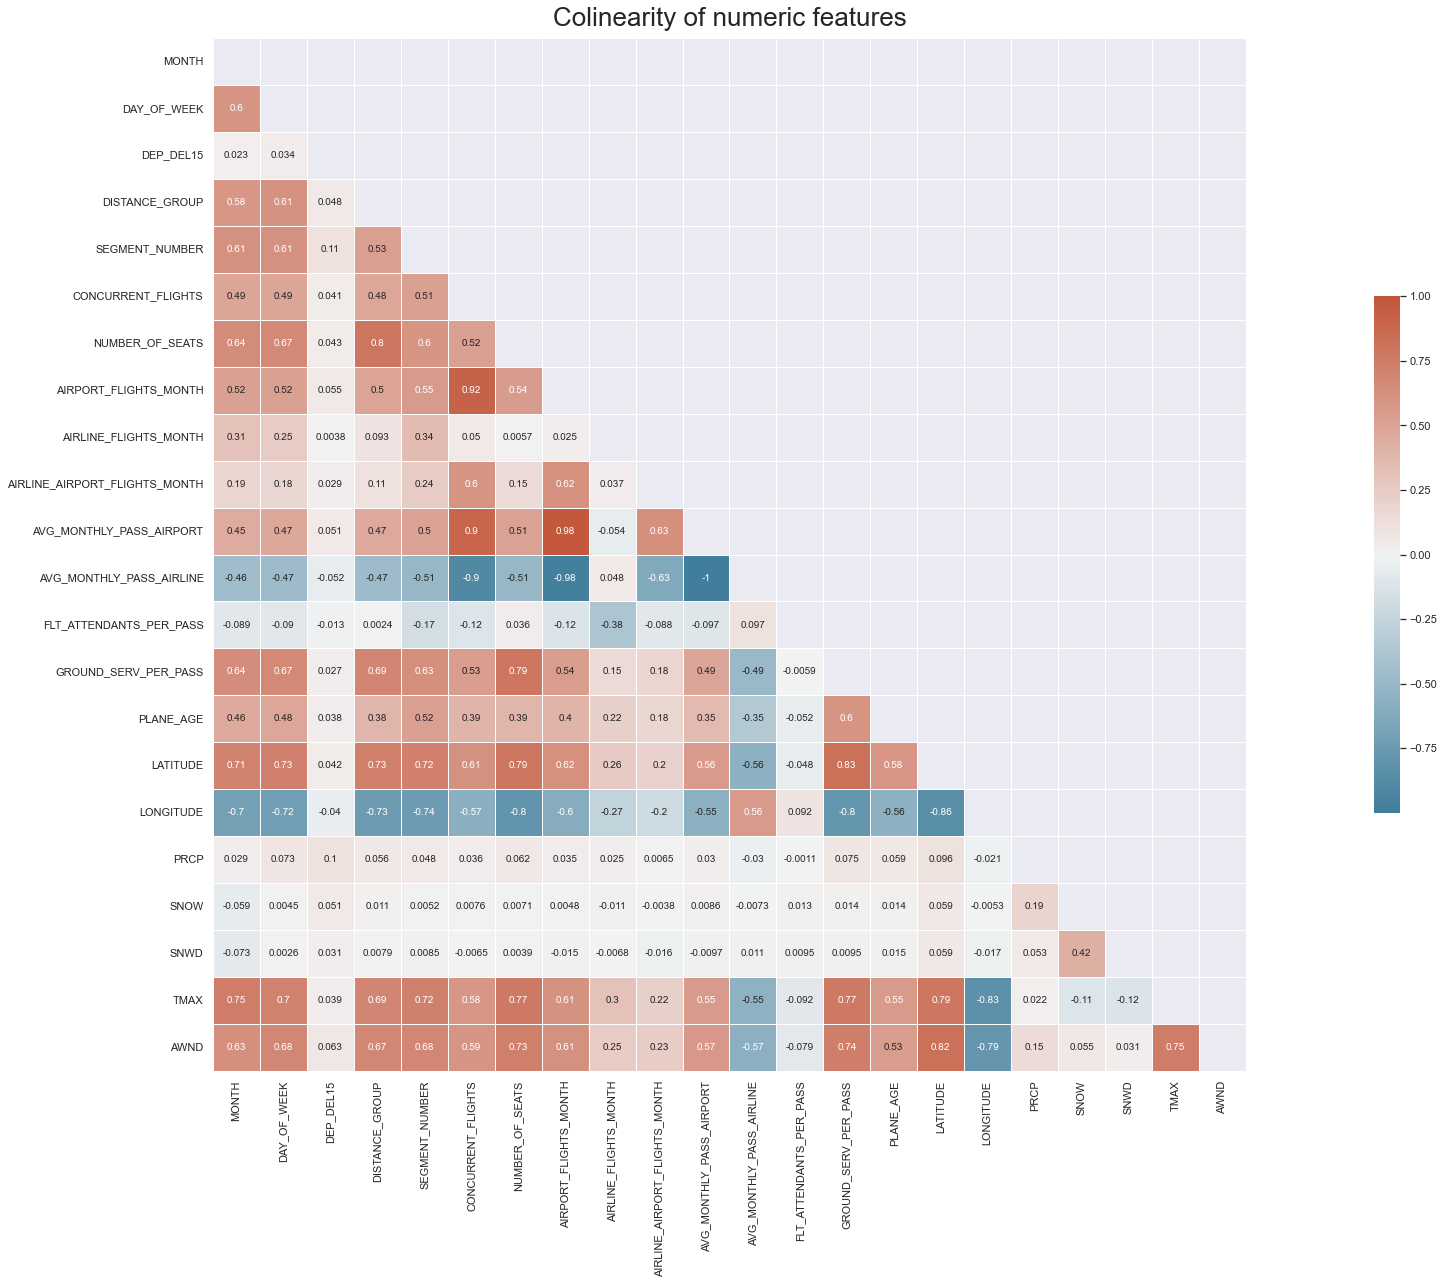

In [9]:
# Seaborn heatmap reference: 
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Select only the numeric features from the dataset
numeric_features_df = df.select_dtypes(['int32', 'float64'])

# Normalize and then compute a pairwise correlation of numeric columns
normalized_pd = pd.DataFrame(Normalizer().fit_transform(numeric_features_df), columns = numeric_features_df.columns)
corr = normalized_pd.corr('spearman')

# Mask the upper triangle of the heatmap and create a diverging colormap
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap
f, ax = plt.subplots(figsize=(46, 19))
corr_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
                           linewidths=.5, cbar_kws={"shrink": .5}, annot=True, 
                           annot_kws={"fontsize":10})

# Set the heatmap title
corr_heatmap.set_title('Colinearity of numeric features', fontdict={'fontsize':26}, pad=12);

The heatmap shows some highly correlated numeric features. For example, the average airport flights per month (`AIRPORT_FLIGHTS_MONTH`) is highly correlated with the average airport departing passengers per month (`AVG_MONTHLY_PASS_AIRPORT`), which we may expect.

The following algorithm should target and remove highly correlated features from the dataset using the heuristic above.

In [10]:
# Select the upper triangle of correlation matrix using our mask
corr_matrix = corr.where(cond=mask)

# Remove redundant features according to heuristic:
# If |p| >= 0.90 remove the feature less correlated to target class 'DEP_DEL15'
redundant_features = []
for col in corr_matrix:
    current_column = corr_matrix[col]       # Iterate over columns in the correlation matrix
    if current_column.name == 'DEP_DEL15':  # Ignore our target class
        continue
    else:
        for row in current_column.index:    # Select each row in the current column
            if current_column.name == row:  # Ignore correlation between the same row and column
                continue
            if np.abs(current_column[row]) >= 0.90:                  # Select highly correlated |p|>=0.90 features
                target_class_row = corr_matrix.loc['DEP_DEL15'][row] # Check the correlation with our target class
                target_class_col = corr_matrix.loc['DEP_DEL15'][col]
                if target_class_row >= target_class_col:             # Remove feature with lower correlation to target
                    redundant_features.append(current_column.name)
                else:
                    redundant_features.append(row)

# Print and drop redundant features
df.drop(set(redundant_features), axis=1, inplace=True)
print(f"Dropped redundant features:\n{set(redundant_features)}")

Dropped redundant features:
{'AVG_MONTHLY_PASS_AIRLINE', 'AVG_MONTHLY_PASS_AIRPORT', 'CONCURRENT_FLIGHTS'}


**Flight delays by month and weekday**

In this section, I will be investigating how delays vary over months and days of the week. My intuition tells me that holiday months and Mondays should have a higher incidence of delays due to more congestion at the airport.

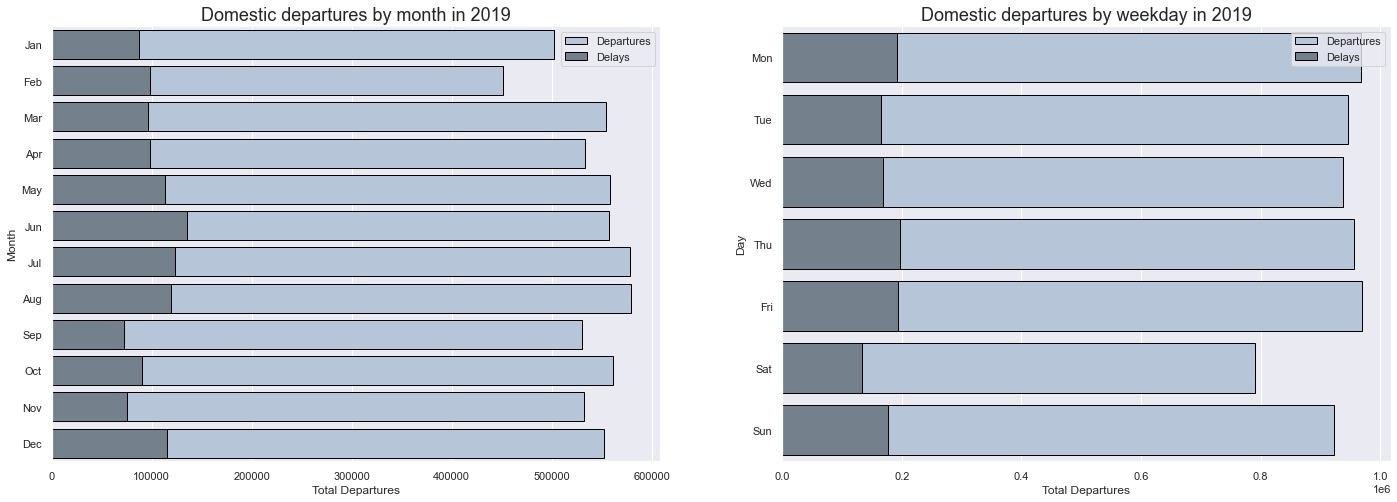

In [89]:
# Create dataframes to organize and sort the frequency data
month_df = pd.DataFrame({
    'MONTHLY_TOTAL'  :  df.groupby(['MONTH']).size(),
    'MONTHLY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['MONTH']).size(),
})
day_df = pd.DataFrame({
    'WEEKDAY_TOTAL'  :  df.groupby(['DAY_OF_WEEK']).size(),
    'WEEKDAY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['DAY_OF_WEEK']).size()
})

# Plot frequency of monthly delays
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x="MONTHLY_TOTAL", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="MONTHLY_DELAYS", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Plot frequency of week day delays
sns.barplot(x="WEEKDAY_TOTAL", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="WEEKDAY_DELAYS", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Configure plot labels
ax1.set_title('Domestic departures by month in 2019', fontdict={'fontsize':18})
ax2.set_title('Domestic departures by weekday in 2019', fontdict={'fontsize':18})
ax1.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.legend(ncol=1, loc="upper right", frameon=True), ax2.legend(ncol=1, loc="upper right", frameon=True)
ax1.set_xlabel("Total Departures"), ax1.set_ylabel("Month")
ax2.set_xlabel("Total Departures"), ax2.set_ylabel("Day");

The month of August has the most departures, followed by July. The fewest departures occur on February and Saturday's. The largest number of delays occur on June and on Thursday. However, the all days of the week appear to have a comparable number of delays. 

**Distribution of plane age**

Next I will investigate whether delayed flights involve more older planes. In order to do this, I will plot the relative frequency of planes by age for both delayed and on-time flights.

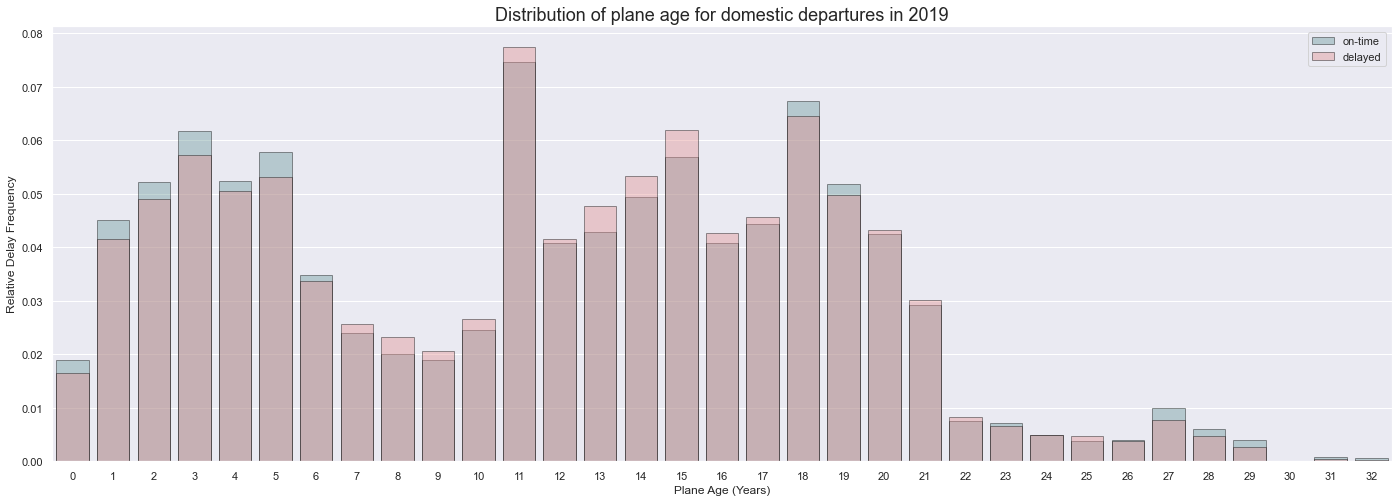

In [104]:
# Select delayed and ontime departures and sort by plane age
ontime_df = df[df['DEP_DEL15'] == 0].sort_values(['PLANE_AGE'], ascending=True)
delay_df = df[df['DEP_DEL15'] == 1].sort_values(['PLANE_AGE'], ascending=True)

# Compute the relative frequency of planes for each age group
ontime_df['AGE_PCT'] = ontime_df['PLANE_AGE'].map(ontime_df['PLANE_AGE'].value_counts(normalize=True))
delay_df['AGE_PCT'] = delay_df['PLANE_AGE'].map(delay_df['PLANE_AGE'].value_counts(normalize=True))

# Pair the age percentage with each unique plane age
ontime_df = ontime_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]
delay_df = delay_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]

# Plot the percentage of planes in each age group for delayed and on-time flights
ax = plt.subplots()
ax = sns.barplot(x=ontime_df.PLANE_AGE,y=ontime_df.AGE_PCT,color='cadetblue',edgecolor='black',label='on-time',alpha=0.4)
ax = sns.barplot(x=delay_df.PLANE_AGE,y=delay_df.AGE_PCT,color='lightcoral',edgecolor='black',label='delayed',alpha=0.4)
ax.set_title('Distribution of plane age for domestic departures in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Plane Age (Years)"), ax.set_ylabel("Relative Delay Frequency")
plt.legend();

The difference between on-time and delayed departures appears to be quite small. The left hand side of the graph suggests that on-time flights use younger aircraft slightly more frequently than delayed flights. The middle of the graph suggests that delayed flights do use older aircraft slightly more frequently than on-time flights.

**Distribution of delays across airlines**

Next I will plot the distribution of delays across different airlines to see if there are any particular carriers that are better or worse at avoiding delays.

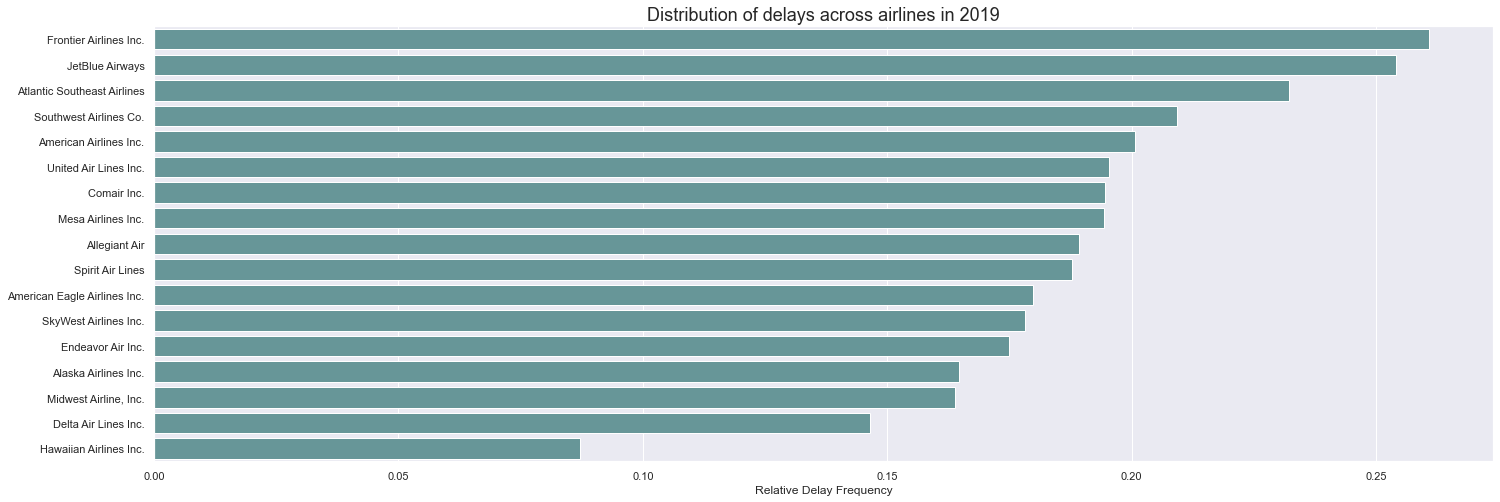

In [13]:
# Select departures grouped by CARRIER_NAME then compute the relative frequency of delays
delay_df = df.groupby(['CARRIER_NAME'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('CARRIER_NAME')

# Plot the distribution of delays
ax = plt.subplots()
ax = sns.barplot(x=x,y=y,color='cadetblue', orient="h")
ax.set_title('Distribution of delays across airlines in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

The clear winner here is Hawaiin Airlines which has the lowest relative delay frequency. The top two airlines are Frontier and Jetblue. I find this a little amusing because I often booked Frontier for flights to CU Boulder and I often encountered delays.

**Distribution of delays across departing airports**

This section is similar to the last, however instead of airline carriers I am plotting the relative frequency of delays over departing airports in the dataset. As with airline carrier, this should be interesting to see if there exist certain airports that are rife with delays. 

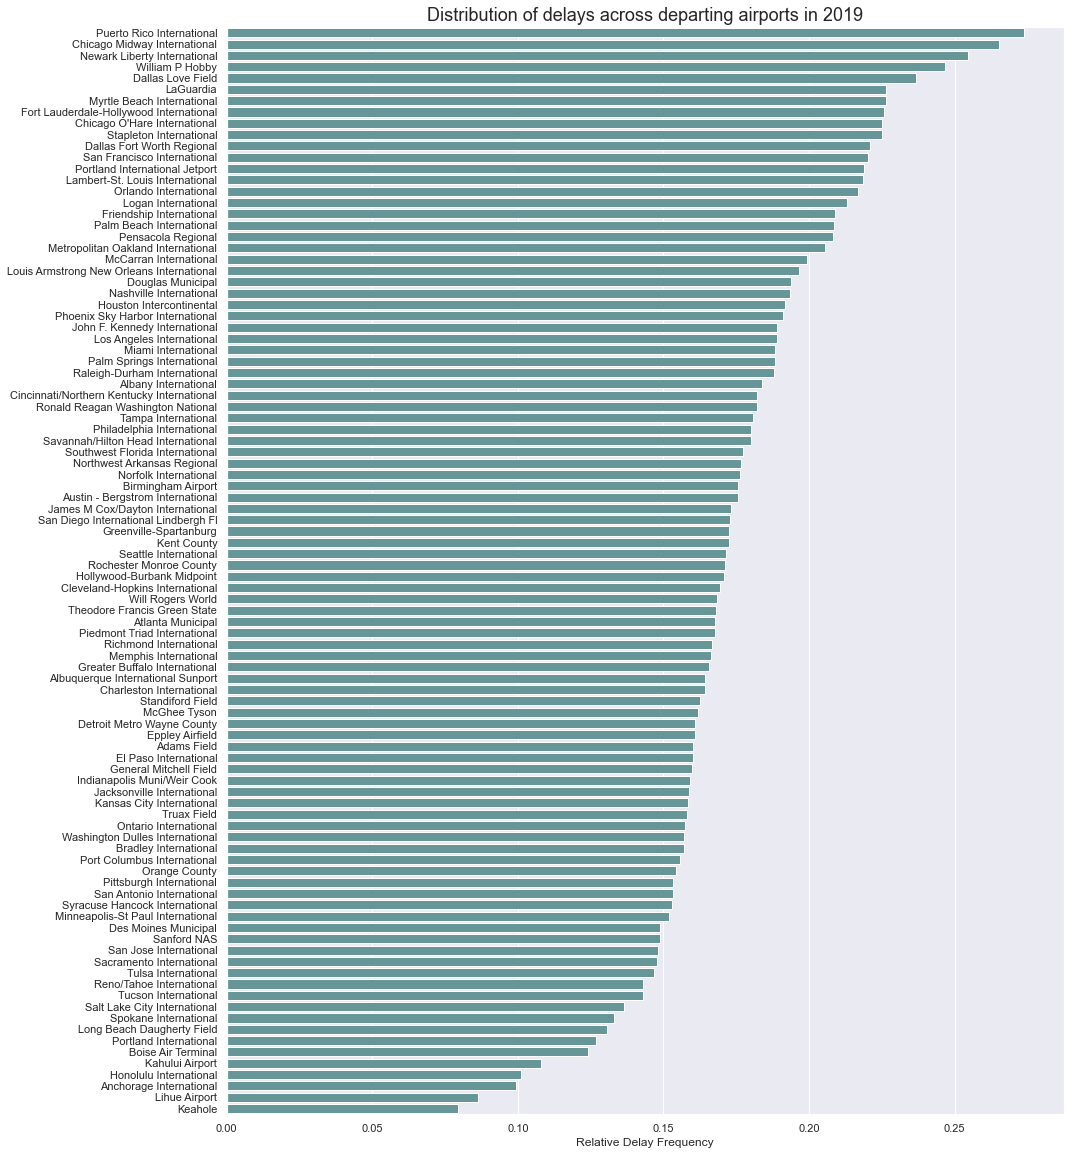

In [14]:
# Select departures grouped by DEPARTING_AIRPORT then compute the relative frequency of delays
delay_df = df.groupby(['DEPARTING_AIRPORT'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('DEPARTING_AIRPORT')

# Plot the distribution of delays
ax = plt.subplots(figsize=(15,20))
ax = sns.barplot(x=x,y=y,color='cadetblue',orient="h")
ax.set_title('Distribution of delays across departing airports in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

**Summary of EDA findings**

* The dataset is biased towards on-time flights.
* The largest number of departure delays occur on June and on Thursday.
* Airlines that are delayed most frequently are: Frontier and Jetblue.
* Airports that are delayed most frequently are: Puerto Rico Intl., Chicago Midway, and Newark Liberty
* `SEGMENT_NUMBER` and `PRCP` have the largest positive correlation with target class `DEP_DEL15`.



**Discussion of forseen difficulties**

EDA has identified foreseen difficulties to consider when selecting a model for this classification task:

1. The target class `DEP_DEL15` is imbalanced: 18.91% of the total flights in the dataset are delayed.
2. There remain an abundance of features after cleaning: 4 categorical, 18 numeric.
3. The dataset is large and may require algorithms with lower computational complexity.
4. Model input is heterogenous.

Each of these difficulties can be mitigated in different ways: 

1. Class imbalance in `DEP_DEL15` may be mitigated by sampling methods, such as oversampling delayed or undersampling on-time flights. 
2. Heterogenous input may require encoding categorical features, or selecting a model that can handle categorical and numeric features. 
3. Since the input size is quite large, it will be important to select models whose complexity has a lower polynomial $k$ of the input size $n$, i.e. $n^k$.

## Plans for Model Approach:

**Logistic regression**

The first classification algorithm that I plan to use is simple logistic regression. The reasons for this are:

1. Target class `DEP_DEL15` is categorical and binary which is well suited for logistic regression.

2. The algorithm is simple to run, resistant to overfitting, and can act as a starting point before attempting more advanced classification models.

3. The interpretability is high which allows us to better understand how the model predicts delays from the features.

4. It has favorable training time complexity $\mathcal{O}(n p)$ and test time complexity $\mathcal{O}(p)$ for the large input data $n$ and predictors $p$ in this dataset.

One important caveat with logistic regression is that real-world data isn't often modeled very well with a linear decision boundary. In other words, it's unlikely that flight delays are bounded by some linear combination of weather conditions, airline traffic, or airports.

Furthermore, logistic models perform poorly with highly correlated features. The correlation matrix in EDA did identify and remove some highly correlated features, but there remain features that are moderately correlated with $|\rho| >= 0.50$.

In light of these difficulties, I will relegate logistic regression as a first pass attempt at classifying flight delays. After performing logistic regression, I will asses the accuracy of its predictions and then see if a more advanced algorithm can achieve greater model accuracy.


**Random Forest**

The second classification algorithm that I plan to use is the random forest ensemble method. The reasons for this are:

1. It handles non-linear parameters and is immune to highly correlated features, which are both improvements from the logistic model.

2. It can leverage the size of the dataset by generating larger bootstrapped sampling distributions with lower standard error.

3. As with logistic regression, interpretability of each decision tree is high and features can be ranked in terms of importance.

4. The training time complexity for $k$ trees, $n$ data points, and $p$ predictors is $\mathcal{O}(n\text{log}(n)pk)$ which is favorable for the large $n$ in this dataset.

The random forest model will require some parameter tuning and that could create some challenges due to the size of the dataset. For example, increasing the total number of trees and their depth might improve model accuracy, but it could create large increases in space and time complexity. 

In addition, random forest and logistic regression models will both be sensitive to feature imbalances in the training data. This imbalance does exist, as shown during EDA. The target class `DEP_DEL15` labels 81.09% on-time flights and only 18.91% delayed flights. If we were to train either model with a similarly imbalanced set of training data, the model could predict all flights as on-time and still be correct 81.09% of the time. Therefore, in both models, great care must be taken to balance the target class.

In the case of the logistic model, I will attempt to balance `DEP_DEL15` by using re-sampling methods, such as oversampling delayed flights or undersampling on-time flights. In the case of random forest, I can balance by using these re-sampling methods during the bootstrap step.